**Compare and debug the C LAL implementation of the surrogate**

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
from scipy import interpolate

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import lal
import lalsimulation as LS

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import lalsimulation
reload(lalsimulation)
import lalsimulation as LS

import constants
imp.reload(constants)
from constants import *

__init__: Setting weave cache to /var/folders/8s/kg3qdn9s10v11v8zq2fgf94h0000gn/T/501_python27_compiled/f26702/f26702be568e3c613857548d8158e9baa1c66daf


# Notes

Ben: 
  * data file for my new method of generating surrogates using splines instead of reduced bases. 
  * The class in the gpsurrogate repository that implements this is called `GPSplineSurrogate`: https://github.com/benjaminlackey/gpsurrogate/blob/master/src/surrogate.py#L498
  * Still using `taylorf2_amp_1pn` in https://github.com/benjaminlackey/gpsurrogate/blob/master/src/taylorf2.py#L237
  

Ben: The relevant functions for doing the interpolation are kernel() and gp_predict() found here:
https://github.com/benjaminlackey/gpsurrogate/blob/master/notebooks/EOB/LalsuiteSurrogate.ipynb
They take in arrays and return scalars.

* The output of gp_predict() are the amplitude and phase at the EI nodes
* Dot these into the amplitude and phase bases that should also be in the HDF5 file
* To obtain the waveform need the TF2 waveform: [taylorf2.py](https://github.com/benjaminlackey/gpsurrogate/blob/master/src/taylorf2.py)
* Take a look at the surrogate class: surrogate.py
  - See [reconstruct_amp_phase_difference()](https://github.com/benjaminlackey/gpsurrogate/blob/master/src/surrogate.py#L142)


```
    namp_nodes = len(damp_gp_list)
    nphase_nodes = len(dphase_gp_list)

    # Calculate waveform at nodes
    amp_at_nodes = np.array([damp_gp_list[j].predict(np.atleast_2d(params))[0] for j in range(namp_nodes)])
    phase_at_nodes = np.array([dphase_gp_list[j].predict(np.atleast_2d(params))[0] for j in range(nphase_nodes)])

    # Get complex version of B_j's in array form
    Bamp_j_array = np.array([Bamp_j[j].amp for j in range(namp_nodes)])
    Bphase_j_array = np.array([Bphase_j[j].phase for j in range(nphase_nodes)])

    # Evaluate waveform
    amp_interp = np.dot(amp_at_nodes, Bamp_j_array)
    phase_interp = np.dot(phase_at_nodes, Bphase_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = Bamp_j[0].x
    return wave.Waveform.from_amp_phase(xarr, amp_interp, phase_interp)
```


Also
```
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

```

Check all hdf5 groups and attributes with:

h5dump -n 1 lalsuitetest.hdf5

This prints the description attribute:

h5dump -a description lalsuitetest.hdf5 

# Construct surrogate in way that can be directly converted to lalsuite code

In [4]:
def kernel(x1, x2, hyperparams):
    """Matern covariance function for n-dimensional data.
    
    Parameters
    ----------
    x1 : array with shape ndim
    x2 : array with shape ndim
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n]
        sigma_f : Approximately the range (ymax-ymin) of values that the data takes.
            sigma_f^2 called the signal variance.
        sigma_n : Noise term. The uncertainty in the y values of the data.
        lsi : Length scales for the variation in dimension i.
    
    Returns
    -------
    covariance : float
    """
    sigma_f = hyperparams[0]
    sigma_n = hyperparams[-1]
    ls = hyperparams[1:-1]
    ndim = len(ls)
    
    # Noise nugget for diagonal elements
    if np.array_equal(x1, x2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    
    # r**2
    rsq = np.sum(np.array([(x1[i]-x2[i])**2 / ls[i]**2 for i in range(ndim)]))
    r = np.sqrt(rsq)
    
    # nu = 5/2 Matern covariance
    matern = (1. + np.sqrt(5.)*r + 5.*r**2/3.) * np.exp(-np.sqrt(5.)*r)
    
    # Full covariance
    # You must include the nugget to agree with scikit-learn when the points x1, x2 are exactly the same
    
#     print "** kernel **"
#     print "x1 =", x1
#     print "x2 =", x2
#     print "ls =", ls
#     print "(x1 - x2) / ls = ", np.array([(x1[i]-x2[i]) / ls[i] for i in range(ndim)])
#     print "r =", r
#     print "eval =", sigma_f**2 * matern + nugget
    
    return sigma_f**2 * matern + nugget

In [5]:
def gp_predict(xst, hyperparams, x_train, Kinv_dot_y):
    """Interpolate the function at the point xst using Gaussian process regression.
    
    Parameters
    ----------
    xst : array of shape ndim.
        Point x_* where you want to evaluate the function.
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n].
        Hyperparameters for the GPR kernel.
    x_train : array of shape (n_train, ndim).
        Training set points.
    Kinv_dot_y : array of shape n_train.
        The interpolating weights at each training set point.
    
    Returns
    -------
    yst : float
        Interpolated value at the point xst.
    """
    # Evaluate vector K_*
    Kst = np.array([kernel(xst, x, hyperparams) for x in x_train])
#     print 'Kst', Kst
#     print 'Kinv_dot_y', Kinv_dot_y[:]

    # Evaluate y_*
    return np.dot(Kst, Kinv_dot_y)

In [6]:
def extract_data_from_scikit_learn(gp):
    """Extract the data in the scikit-learn GaussianProcessRegressor class 
    that you need for the lalsuite version.
    """
    # hyperparams = np.array([sigma_f, lq, ls1, ls2, llam1, llam2, sigma_n])
    hyperparams = gpr.get_hyperparameters(gp)
    
    # The training data
    x_train = gp.X_train_
    y_train = gp.y_train_
    
    # Evaluate K
    K = np.array([[kernel(x1, x2, hyperparams) for x2 in x_train] for x1 in x_train])
    
    # Evaluate K^{-1}
    Kinv = np.linalg.inv(K)
    
    # Evaluate (K^{-1})_{ij} y_j (array of length nparams).
    Kinv_dot_y = np.dot(Kinv, y_train)
    
    return hyperparams, x_train, Kinv_dot_y

In [7]:
import taylorf2

def geometric_reference_waveform(params, mf):
    """Reference TaylorF2 waveform in geometric units
    evaluated at the same times as the surrogate of the difference.
    """
    q, s1, s2, lambda1, lambda2 = params
    h_ref = taylorf2.dimensionless_taylorf2_waveform(
        mf=mf, q=q,
        spin1z=s1, spin2z=s2,
        lambda1=lambda1, lambda2=lambda2)

    # Reference waveform has zero starting phase
    h_ref.add_phase(remove_start_phase=True)
    return h_ref

In [8]:
# `geometric_reference_waveform()` calls `dimensionless_taylorf2_waveform()`:

def dimensionless_taylorf2_waveform(
    mf=None, q=None,
    spin1x=None, spin1y=None, spin1z=None,
    spin2x=None, spin2y=None, spin2z=None,
    lambda1=None, lambda2=None):
    """Waveform suitable for training set.
    """
    tbymc = 0.
    phic = 0.
    eta = q/(1.+q)**2
    #amp = taylorf2_amp(mf, eta)
    # Use the 1pn amplitude
    amp = taylorf2_amp_1pn(mf, eta)
    phase = taylorf2_phase(mf, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
    return wave.Waveform.from_amp_phase(mf, amp, phase)

In [9]:
def TEOB_surrogate_Python(x, mfs):
    # Compute TaylorF2 reference waveform
    h_ref = geometric_reference_waveform(x, mfs)
    # Surrogate of A and \Phi
    h_sur = h_ref.copy()
    h_sur.amp *= np.exp(amp_interp)
    h_sur.phase += phase_interp
    
    return h_sur

In [10]:
# Point exactly in training set:
x_train_point = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

# Test point
x_test_point = np.array([1.0/1.5, 0.35, 0.32, 1000.0, 1500.0])

x = x_test_point

# Load scikit-learn (python) version of surrogate

In [45]:
Bamp_filename = '../../data/teobtest40hz/B_amp_corners_lhd.hdf5'
Bphase_filename = '../../data/teobtest40hz/B_phase_corners_lhd.hdf5'
gp_amp_filename = '../../data/teobtest40hz/gp_amp_corners_lhd.hdf5'
gp_phase_filename = '../../data/teobtest40hz/gp_phase_corners_lhd.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

# Bamp_filename = '../../data/teobtest40hz/B_amp_lhd_uncsamp.hdf5'
# Bphase_filename = '../../data/teobtest40hz/B_phase_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/teobtest40hz/gp_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/teobtest40hz/gp_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

In [46]:
#Random point:
#x = np.array([0.8, 0.2, 0.1, 1000, 2000])

# Point exactly in training set:
x = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

for i in range(len(sur.dphase_gp_list)):
    gp = sur.dphase_gp_list[i]
    #gp = sur.dphase_gp_list[0]
    hyperparams, x_train, Kinv_dot_y = extract_data_from_scikit_learn(gp)

    a = gp.predict(np.atleast_2d(x))[0]
    b = gp_predict(x, hyperparams, x_train, Kinv_dot_y)

    #sigma_n = hyperparams[-1]
    #print sigma_n
    print np.abs(b/a-1.)

5.53723478181e-09
6.42491049252e-09
1.96401661601e-09
5.68317459759e-09
4.66294558521e-09
2.28728636031e-09
2.02868855048e-09
2.36434094525e-10
1.48636081221e-09
2.49062059865e-09
4.93199625584e-09
1.76905234905e-09
3.07067204997e-09
1.08489428552e-09
4.44460579452e-10
2.02839578467e-09
3.19912274449e-09
3.97346355818e-09
1.37696076763e-09
3.79370002079e-09


# Generate hdf5 file for lalsuite version (old format)

In [139]:
def lalsuite_surrogate_format(filename, sur):
    """Write data to an hdf5 file format that can be read by the 
    lalsuite version of the code.
    """
    f = h5py.File(filename, libver='latest')
    
    namp = len(sur.Bamp)
    nphase = len(sur.Bphase)
    
    f.attrs['description'] = \
'''
********************************************************************************
Data for TEOBv4_ROM reduced order model (aligned-spin BNS with tidal interactions).

See B. Lackey, et al. arXiv:xxxx.xxxx.

Parameter ranges:
* 1/3 <= q <= 1
* -0.4 <= spin_1z <= 0.4
* -0.4 <= spin_2z <= 0.4
* 0.1 <= lambda_1 <= 3000
* 0.1 <= lambda_2 <= 3000
* flow >= xxHz

This ROM was built using the TEOBv4 waveform.

The hyperparameters for the Gaussian process regression associated with each 
basis function are listed in the order
[sigma_f, l_q, l_spin1z, l_spin2z, l_lambda1, l_lambda2, sigma_n]
where sigma_f is approximately the function range, sigma_n is the noise/tollerance, 
and l_i is the correlation length scale for the parameter i.
********************************************************************************
'''
    
    # Frequency samples
    f['mf'] = sur.mf
    
    # Training set samples.
    # They are the same for all basis functions so pick amp_0
    gp = sur.damp_gp_list[0]
    x_train = gp.X_train_
    f['x_train'] = x_train
    
    print 'Writing amplitude bases...'
    for i in range(namp):
        print i,
        groupname = 'delta_ln_a_' + str(i)
        group = f.create_group(groupname)
        
        group.attrs['mf_node'] = sur.mf_amp[i]
        group['basis'] = sur.Bamp[i].amp
    
        gp = sur.damp_gp_list[i]
        hyperparameters, x_train, kinv_dot_y = extract_data_from_scikit_learn(gp)
        group['hyperparameters'] = hyperparameters
        group['kinv_dot_y'] = kinv_dot_y
        
    print '\nWriting phase bases...'
    for i in range(nphase):
        print i,
        groupname = 'delta_phi_' + str(i)
        group = f.create_group(groupname)
        
        group.attrs['mf_node'] = sur.mf_phase[i]
        group['basis'] = sur.Bphase[i].phase
        
        gp = sur.dphase_gp_list[i]
        hyperparameters, x_train, kinv_dot_y = extract_data_from_scikit_learn(gp)
        group['hyperparameters'] = hyperparameters
        group['kinv_dot_y'] = kinv_dot_y
        
    f.close()

In [140]:
filename = 'lalsuitetest.hdf5'
lalsuite_surrogate_format(filename, sur)

Writing amplitude bases...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Writing phase bases...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


## Testing

In [141]:
f = h5py.File(filename, libver='latest')

In [142]:
print f['mf'][:].shape
print f['x_train'][:].shape

(10000,)
(159, 5)


In [143]:
print f['delta_ln_a_19'].attrs['mf_node']
print f['delta_ln_a_19/hyperparameters'][:]
print f['delta_ln_a_19/kinv_dot_y'][:]
print f['delta_ln_a_19/basis'][:]

0.03
[  1.244054e+00   5.415526e-01   2.404507e+00   3.200000e+00   1.210941e+03   6.054942e+03   1.816954e-02]
[  1.353636e-01  -2.426995e+00   1.238622e+00   2.569431e+00   3.361933e+00   1.419202e+01  -3.627787e+00
  -8.324047e-01  -1.272532e-01  -3.368970e+01  -2.408338e+00  -1.902484e+00   5.119303e+00   4.062834e+00
   1.460107e+00   3.370889e-01  -2.491526e+00   5.354783e+00   7.465732e-01   4.420478e+01   3.176610e+00
  -5.925059e+00   1.808938e+00  -1.110560e+01   5.000668e+00   6.217673e+00   4.195432e+00  -1.312605e+01
   2.338496e-01   5.919319e+00  -5.379469e+00   1.755869e+01  -1.626893e+01   1.689817e+01  -1.431328e+01
  -1.971245e+01   4.480975e+00   3.670967e+00  -8.873717e+00  -3.385341e+00   6.651964e+00  -8.662202e+00
   8.775134e+00   1.007829e+01   6.649881e+00   3.344075e+00  -4.441547e+00   4.264576e+00  -4.622621e+01
   2.691734e+00  -5.929247e+00   1.690460e+01  -3.125132e+00  -6.299917e+00  -6.306608e+00   1.515829e+00
  -2.227001e+00   7.702309e+00  -3.24518

In [144]:
print f['delta_phi_19'].attrs['mf_node']
print f['delta_phi_19/hyperparameters'][:]
print f['delta_phi_19/kinv_dot_y'][:]
print f['delta_phi_19/basis'][:]

0.03
[  4.255004e+02   1.421491e+00   8.000000e+00   8.000000e+00   8.187851e+03   2.999900e+04   5.062750e-04]
[ 0.161461  0.096188  0.054938  0.327947  0.020727  0.155349 -0.008214 -0.051078  0.235633 -1.000358 -0.042436
 -0.307369  0.988341  0.073701 -0.252881 -0.108205  0.246872  0.052102  0.069441  0.30316  -0.022522 -0.11242
  0.059793 -0.139292  0.20552   0.93233   0.06626  -0.077352  0.774753 -0.627922  0.019855 -0.027874 -0.483242
  0.005088 -0.785822  0.01263   0.400281 -0.800456 -0.580188 -0.260387  0.319411 -0.537523 -0.132596  1.483104
  0.070138 -0.224954 -0.858842  0.713094 -0.410665  0.833558 -0.047864  1.206982 -0.867527 -0.117764  0.446977
  0.055848 -0.876076  0.164289 -0.036691 -0.899262  0.083572  0.165041  0.863735  0.356303 -1.582601  2.375573
  0.56885  -0.553988  0.031443  0.069171  0.268207 -0.297621 -1.257951  0.369415 -0.753824 -0.027229 -0.904814
  0.22315  -0.271993  0.689553  0.709485 -0.88239  -0.703084 -0.80746  -0.595217  0.274676 -0.718739 -0.869145
 

In [145]:
f.close()

# Test code using lalsimulation HDF5 data (old format)

The output of the lalsimulation code has to agree with the output of the code below.

In [7]:
filename = 'lalsuitetest.hdf5'
f = h5py.File(filename, 'r')

File structure:

    'mf'
    'x_train'
    'delta_ln_a_i': 'basis', 'hyperparameters', 'kinv_dot_y'
    'delta_phi_i': 'basis', 'hyperparameters', 'kinv_dot_y'
    
i.e. 'hyperparameters', 'kinv_dot_y' are different for each amplitude and phase coefficient gp fit and 'basis' gives the i-th basis function

* There could be an attribute in the HDF5 file telling us how many amplitude and phase coefficients there are in total. Although we could query this.

* There are 10000 points in mf. Isn't this overkill? Also, how were these points chosen? MP thinks that a few hundred points should suffice. Interpolation in frequency needs to be done at any rate since the user can specify Deltaf freely. Presumably this interpolation of the fully assembled amplitude and phase in frequency should be done by some sort of spline.

In [21]:
# Compute amplitude and phase coefficients for an example point

# Point exactly in training set:
x = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

n = 20 # FIXME: should be read from an attribute
for i in range(n):
    grp_ln_a = f['delta_ln_a_%d'%i]
    grp_phi = f['delta_phi_%d'%i]
    print gp_predict(x, grp_ln_a['hyperparameters'], f['x_train'], grp_ln_a['kinv_dot_y']), gp_predict(x, grp_phi['hyperparameters'], f['x_train'], grp_phi['kinv_dot_y'])

-0.0873621747291 2.67268739046
-0.127697708695 8.04386720647
-0.142636962932 19.6197273431
-0.150228252721 20.5559015819
-0.157051635052 24.9972548013
-0.162628411644 26.1481786918
-0.183240290086 27.5302242225
-0.20070751982 28.8042031484
-0.218269466269 30.1149581712
-0.23251895837 33.2215152853
-0.246764670981 35.2173137722
-0.289641481501 37.6413768021
-0.302604115733 40.1108972129
-0.338274141305 42.9222709187
-0.381038556706 47.6703481679
-0.429119310859 55.3266617441
-0.476853385203 62.517613797
-0.544626065822 72.5862838226
-0.52161738489 80.1487817264
-0.473509283346 85.0782840175


In [8]:
# Compute amplitude and phase coefficients for an example point

# Point exactly in training set:
x = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

n = 20 # FIXME: should be read from an attribute

# Calculate waveform at nodes
amp_at_nodes = np.array([gp_predict(x, 
                                    f['delta_ln_a_%d/hyperparameters'%i], 
                                    f['x_train'], 
                                    f['delta_ln_a_%d/kinv_dot_y'%i]) 
                         for i in range(n)])

phase_at_nodes = np.array([gp_predict(x, 
                                      f['delta_phi_%d/hyperparameters'%i], 
                                      f['x_train'], 
                                      f['delta_phi_%d/kinv_dot_y'%i]) 
                           for i in range(n)])

In [9]:
# Get arrays of amplitude and phase bases
Bamp_j_array = np.array([f['delta_ln_a_%d/basis'%i][:] for i in range(n)])
Bphase_j_array = np.array([f['delta_phi_%d/basis'%i][:] for i in range(n)])

In [10]:
# Evaluate waveform
amp_interp = np.dot(amp_at_nodes, Bamp_j_array)
phase_interp = np.dot(phase_at_nodes, Bphase_j_array)

In [18]:
amp_interp

array([-0.019851, -0.019857, -0.019863, ..., -0.474016, -0.473763, -0.473509])

In [11]:
phase_interp

array([  0.000000e+00,   1.056314e-03,   2.112993e-03, ...,   8.503017e+01,   8.505423e+01,   8.507828e+01])

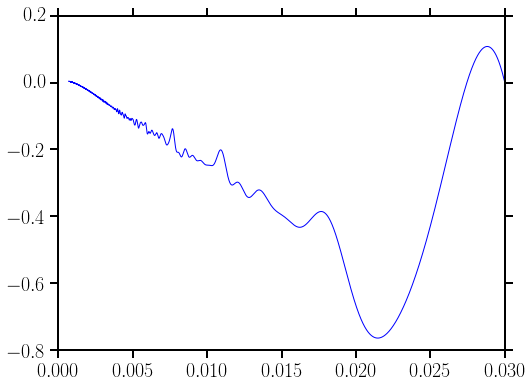

In [14]:
plt.plot(f['mf'], amp_interp)

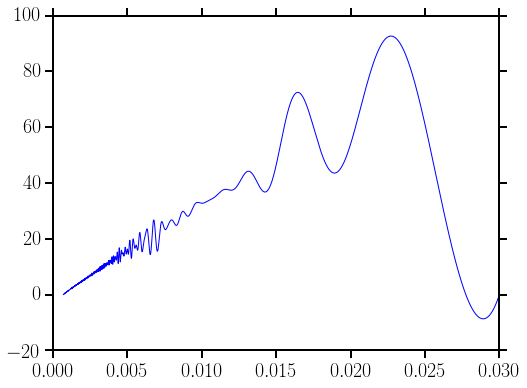

In [44]:
plt.plot(f['mf'], phase_interp)

In [48]:
import taylorf2

def geometric_reference_waveform(params, mf):
    """Reference TaylorF2 waveform in geometric units
    evaluated at the same times as the surrogate of the difference.
    """
    q, s1, s2, lambda1, lambda2 = params
    h_ref = taylorf2.dimensionless_taylorf2_waveform(
        mf=mf, q=q,
        spin1z=s1, spin2z=s2,
        lambda1=lambda1, lambda2=lambda2)

    # Reference waveform has zero starting phase
    h_ref.add_phase(remove_start_phase=True)
    return h_ref

In [51]:
# Compute TaylorF2 reference waveform
h_ref = geometric_reference_waveform(x, f['mf'][:])

In [55]:
# Surrogate of A and \Phi
h_sur = h_ref.copy()
h_sur.amp *= np.exp(amp_interp)
h_sur.phase += phase_interp

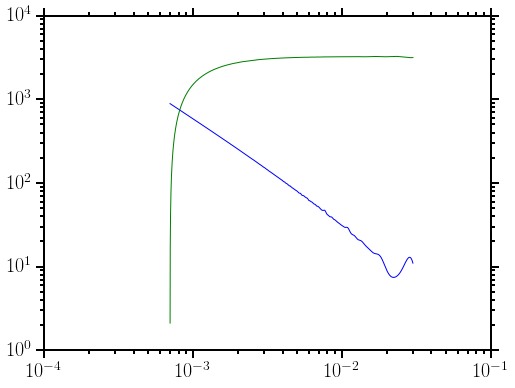

In [59]:
loglog(h_sur.x, h_sur.amp)
loglog(h_sur.x, h_sur.phase)

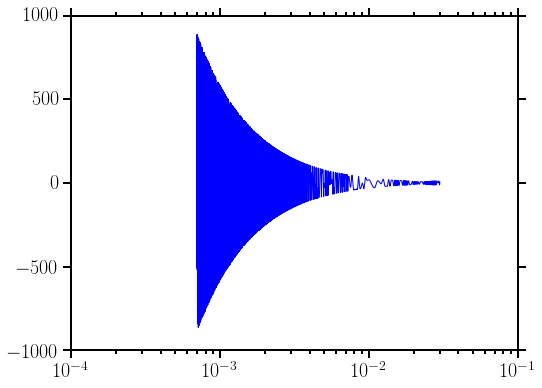

In [62]:
semilogx(h_sur.x, h_sur.amp * np.exp(1j * h_sur.phase))

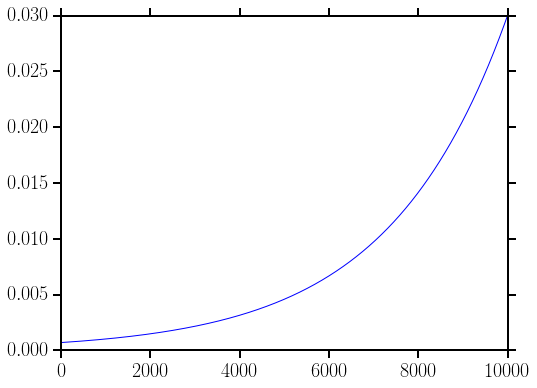

In [63]:
plot(f['mf'])

## Save matrix data

Make it easier to read the surrogate data in C

* To make the C code easier store for amplitude and phase:
    * hyperparameters as a matrix (n_EI_nodes, n_hyp)
    * kinv_dot_y as a matrix (n_EI_nodes, n_train)
    * bases as a matrix (n_EI_nodes, n_freqs)
    * EI_nodes (n_EI_nodes)


In [23]:
# Read the current HDF5 format
n_EI_nodes = 20
n_train = 159

hyp_amp = np.array([f['delta_ln_a_%d/hyperparameters'%i][:] for i in range(n_EI_nodes)])
hyp_phi = np.array([f['delta_phi_%d/hyperparameters'%i][:] for i in range(n_EI_nodes)])

kinv_dot_y_amp = np.array([f['delta_ln_a_%d/kinv_dot_y'%i][:] for i in range(n_EI_nodes)])
kinv_dot_y_phi = np.array([f['delta_phi_%d/kinv_dot_y'%i][:] for i in range(n_EI_nodes)])

B_amp = np.array([f['delta_ln_a_%d/basis'%i][:] for i in range(n_EI_nodes)])
B_phi = np.array([f['delta_phi_%d/basis'%i][:] for i in range(n_EI_nodes)])

EI_nodes_amp = np.array([f['delta_ln_a_%d'%i].attrs['mf_node'] for i in range(n_EI_nodes)])
EI_nodes_phi = np.array([f['delta_phi_%d'%i].attrs['mf_node'] for i in range(n_EI_nodes)])


# Save data to new HDF5 file
fp = h5py.File('lalsuitetest_new.hdf5', 'w')
# Copy some datasets
fp.attrs['description'] = f.attrs['description']
fp['mf'] = f['mf'][:]
fp['x_train'] = f['x_train'][:]
# Save matrix data
fp['hyp_amp'] = hyp_amp
fp['hyp_phi'] = hyp_phi
fp['kinv_dot_y_amp'] = kinv_dot_y_amp
fp['kinv_dot_y_phi'] = kinv_dot_y_phi
fp['B_amp'] = B_amp
fp['B_phi'] = B_phi
fp['EI_nodes_amp'] = EI_nodes_amp
fp['EI_nodes_phi'] = EI_nodes_phi
fp.close()

## Ongoing testing of C code

In [4]:
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = 30*lal.MSUN_SI, 10*lal.MSUN_SI, -0.4, -0.4, 0.1, 0.1, -1

hp, hc = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max)

* Use Ben's updated HDF5 file: TEOBv4_ROM.hdf5
* Implement checks on parameter bounds
* Implement checks on dataset sizes? Remove all hardwired sizes.

# Test code using lalsimulation HDF5 data (new format)

## Compare surrogate amplitude and phase corrections

In [8]:
%%bash
h5ls TEOBv4_surrogate.hdf5

chi1_bounds              Dataset {2}
chi2_bounds              Dataset {2}
hyp_amp                  Dataset {20, 7}
hyp_phi                  Dataset {19, 7}
kinv_dot_y_amp           Dataset {20, 159}
kinv_dot_y_phi           Dataset {19, 159}
lambda1_bounds           Dataset {2}
lambda2_bounds           Dataset {2}
q_bounds                 Dataset {2}
spline_nodes_amp         Dataset {20}
spline_nodes_phase       Dataset {19}
x_train                  Dataset {159, 5}


The output of the lalsimulation code has to agree with the output of the code below.

In [9]:
filename = 'TEOBv4_surrogate.hdf5'
f = h5py.File(filename, 'r')

File structure:

    'x_train': N_train x 5
    'hyp_amp': N_amp x 7
    'hyp_phi': N_phi x 7
    'kinv_dot_y_amp': N_amp x N_train
    'kinv_dot_y_phase': N_phi x N_train
    'spline_nodes_amp': N_amp
    'spline_nodes_phase': N_phi
    
'hyperparameters' and 'kinv_dot_y' are different for each amplitude and phase gp fit and corresponding to a spline frequency.

In [10]:
# Compute amplitude and phase coefficients for an example point

for i in range(19):
    kinv_dot_y_amp_i = f['kinv_dot_y_amp'][i]
    kinv_dot_y_phi_i = f['kinv_dot_y_phi'][i]
    hyp_amp_i = f['hyp_amp'][i]
    hyp_phi_i = f['hyp_phi'][i]
    print gp_predict(x, hyp_amp_i, f['x_train'], kinv_dot_y_amp_i), gp_predict(x, hyp_phi_i, f['x_train'], kinv_dot_y_phi_i)

0.000417468676682 0.00398212206198
0.000510250185245 0.0224069292576
0.000641214987668 0.0644115795806
0.000793040177837 0.143289155992
0.000959420990183 0.278472938253
0.00112208559039 0.497947662748
0.00124632175021 0.841721123956
0.00125456102254 1.36662681954
0.000973438615378 2.15358302931
1.19103493521e-05 3.31917165331
-0.00264500385665 5.03916759617
-0.0104156319979 7.63255177679
-0.0404758669926 11.9108462768
-0.214962941245 19.9336480092
-0.606760927793 31.9706550313
-0.966610787504 45.0766929848
-1.73717146107 53.0544741406
-3.35732228511 43.6194524202
-6.14267216203 -11.3252187934


In [11]:
# Compute amplitude and phase coefficients for an example point

N_amp = len(f['spline_nodes_amp'])
N_phi = len(f['spline_nodes_phase'])
print N_amp, N_phi

# Calculate waveform at nodes
amp_at_nodes = np.array([gp_predict(x,
                                    f['hyp_amp'][i], 
                                    f['x_train'], 
                                    f['kinv_dot_y_amp'][i]) 
                         for i in range(N_amp)])

phase_at_nodes = np.array([gp_predict(x,
                                      f['hyp_phi'][i], 
                                      f['x_train'], 
                                      f['kinv_dot_y_phi'][i]) 
                           for i in range(N_phi)])

20 19


In [12]:
# In reconstruct_amp_phase_difference_spline():
# Prepend the point [mf_a, 0] to the phase nodes
mf_amp = f['spline_nodes_amp'][:]
mf_phase = f['spline_nodes_phase'][:]
mf_min = mf_amp[0] # Follow definition of mf_a in GPSplineSurrogate constructor
mf_phi = np.insert(mf_phase, 0, mf_min)
phase_at_nodes = np.insert(phase_at_nodes, 0, 0.0)

In [13]:
# Output of `SimIMRTEOBv4ROM` Copied from Terminal (command is at top of next section)
amp_at_nodes_LAL = np.array([
0.000417468676682395,
0.000510250185244809,
0.000641214987668309,
0.000793040177837462,
0.000959420990183202,
0.00112208559039317,
0.0012463217502123,
0.00125456102254207,
0.000973438615379574,
1.19103493476658e-05,
-0.00264500385666366,
-0.0104156319978541,
-0.0404758669926233,
-0.214962941244835,
-0.606760927793466,
-0.966610787503829,
-1.73717146106917,
-3.35732228511083,
-6.14267216203261,
-7.53607333402456])

phi_at_nodes_LAL = np.array([
0,
0.00398212206197962,
0.0224069292576032,
0.0644115795806135,
0.143289155992461,
0.278472938253316,
0.497947662747308,
0.841721123954983,
1.36662681953661,
2.15358302930281,
3.31917165331424,
5.0391675961705,
7.63255177677343,
11.9108462767826,
19.9336480092097,
31.9706550311239,
45.0766929849342,
53.0544741402118,
43.6194524202147,
-11.3252187937032])

In [14]:
print mf_amp
print amp_at_nodes
print amp_at_nodes - amp_at_nodes_LAL

[ 0.00021   0.000285  0.000387  0.000525  0.000713  0.000969  0.001315  0.001785  0.002424  0.003291  0.004467
  0.006065  0.008234  0.011179  0.015177  0.020605  0.027974  0.037978  0.05156   0.07    ]
[  4.174687e-04   5.102502e-04   6.412150e-04   7.930402e-04   9.594210e-04   1.122086e-03   1.246322e-03
   1.254561e-03   9.734386e-04   1.191035e-05  -2.645004e-03  -1.041563e-02  -4.047587e-02  -2.149629e-01
  -6.067609e-01  -9.666108e-01  -1.737171e+00  -3.357322e+00  -6.142672e+00  -7.536073e+00]
[ -4.179599e-17   2.362477e-16  -1.355253e-17  -5.830839e-16  -1.112391e-16   1.147086e-16   4.200199e-16
   6.628812e-16  -1.332484e-15   4.440863e-15   1.420739e-14  -9.020562e-16  -2.307876e-14  -5.667689e-14
   7.771561e-14   6.084022e-14  -8.570922e-14   3.641532e-14   3.819167e-14   5.062617e-14]


In [15]:
print mf_phi
print phase_at_nodes
print phase_at_nodes - phi_at_nodes_LAL

[ 0.00021   0.000285  0.000387  0.000525  0.000713  0.000969  0.001315  0.001785  0.002424  0.003291  0.004467
  0.006065  0.008234  0.011179  0.015177  0.020605  0.027974  0.037978  0.05156   0.07    ]
[  0.000000e+00   3.982122e-03   2.240693e-02   6.441158e-02   1.432892e-01   2.784729e-01   4.979477e-01
   8.417211e-01   1.366627e+00   2.153583e+00   3.319172e+00   5.039168e+00   7.632552e+00   1.191085e+01
   1.993365e+01   3.197066e+01   4.507669e+01   5.305447e+01   4.361945e+01  -1.132522e+01]
[  0.000000e+00   2.784231e-16  -5.072331e-15  -4.440892e-14   2.303713e-14  -1.281197e-13   3.833045e-13
   1.307288e-12  -4.873879e-13   3.863576e-12  -5.909051e-12  -4.538592e-13   1.750333e-11   4.188649e-11
   4.003553e-11   1.673435e-10  -1.164153e-10   3.492673e-10   2.906120e-11   3.492033e-10]


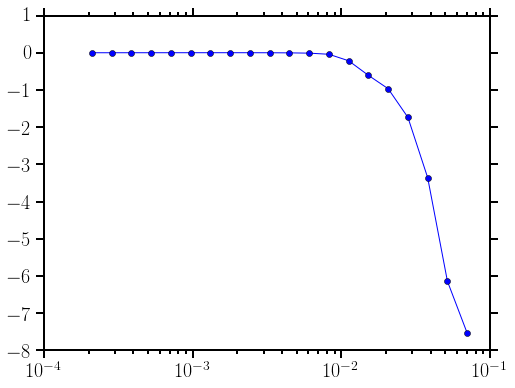

In [16]:
plt.semilogx(mf_amp, amp_at_nodes, 'o-');

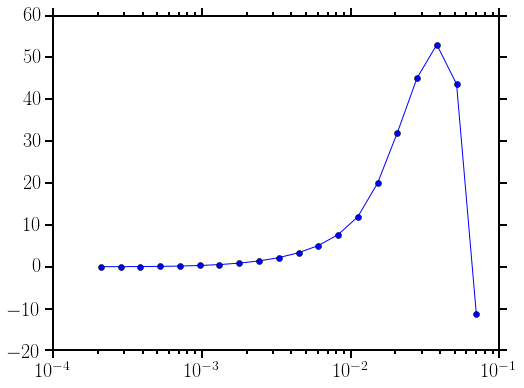

In [17]:
plt.semilogx(mf_phi, phase_at_nodes, 'o-');

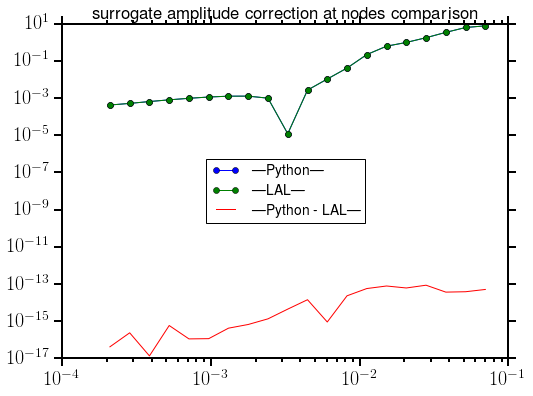

In [18]:
plt.loglog(mf_amp, np.abs(amp_at_nodes), 'o-', label='|Python|')
plt.loglog(mf_amp, np.abs(amp_at_nodes_LAL), 'o-', label='|LAL|')
plt.loglog(mf_amp, np.abs(amp_at_nodes - amp_at_nodes_LAL), label='|Python - LAL|')
plt.legend(loc=10);
plt.title('surrogate amplitude correction at nodes comparison');

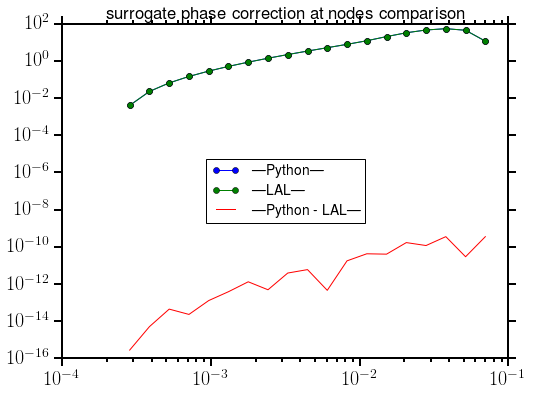

In [19]:
plt.loglog(mf_phi, np.abs(phase_at_nodes), 'o-', label='|Python|')
plt.loglog(mf_phi, np.abs(phi_at_nodes_LAL), 'o-', label='|LAL|')
plt.loglog(mf_phi, np.abs(phase_at_nodes - phi_at_nodes_LAL), label='|Python - LAL|')
plt.legend(loc=10);
plt.title('surrogate phase correction at nodes comparison');

In [20]:
# Interpolate dlnamp and dphase at the frequencies mf_amp and mf_p
ampoff = interpolate.UnivariateSpline(mf_amp, amp_at_nodes, k=3, s=0)
phaseoff = interpolate.UnivariateSpline(mf_phi, phase_at_nodes, k=3, s=0)

In [21]:
# Frequencies for evaluation (only used for testing here)
# Start at approximately 1Hz (mf=1.0e-5) and go up to last spline node
npoints=10000
mfs = np.logspace(-5.0, np.log10(mf_phi[-1]), npoints)

In [22]:
# Evaluate dlnamp and dphase at the frequencies mfs
amp_interp = np.array([ampoff(f) if f>=mf_min else 0.0 for f in mfs])
phase_interp = np.array([phaseoff(f) if f>=mf_min else 0.0 for f in mfs])

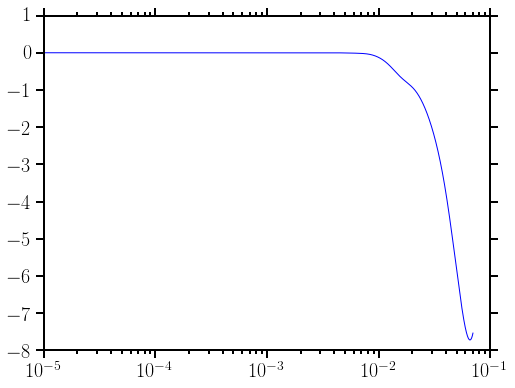

In [23]:
plt.semilogx(mfs, amp_interp);

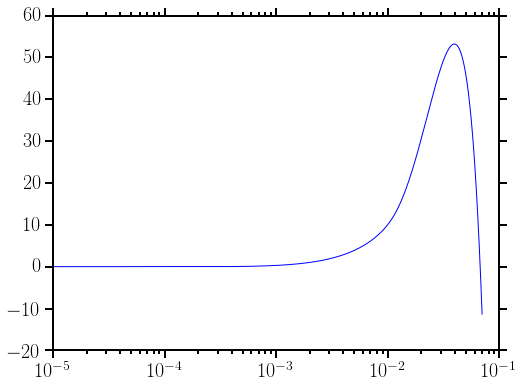

In [24]:
plt.semilogx(mfs, phase_interp);

The code is calling `wave.Waveform.from_amp_phase(mfs, amp_interp, phase_interp)`. This just stores the amplitude and phase in a class.

The complete waveform is reconstructed in `geometric_waveform()`: https://github.com/benjaminlackey/gpsurrogate/blob/master/src/surrogate.py#L559
There, the amplitude and phase corrections are added to the output of `geometric_reference_waveform()`.

```Python
# Surrogate of \Delta\Phi and \Delta\ln A
h_diff_sur = self.amp_phase_difference(params)
# Reference waveform
h_ref = self.geometric_reference_waveform(params)
# Surrogate of A and \Phi
h_sur = h_ref.copy()
h_sur.amp *= np.exp(h_diff_sur.amp)
h_sur.phase += h_diff_sur.phase
```

**TODO:** check whether `geometric_reference_waveform()` has changed.

In [25]:
import taylorf2

def geometric_reference_waveform(params, mf):
    """Reference TaylorF2 waveform in geometric units
    evaluated at the same times as the surrogate of the difference.
    """
    q, s1, s2, lambda1, lambda2 = params
    h_ref = taylorf2.dimensionless_taylorf2_waveform(
        mf=mf, q=q,
        spin1z=s1, spin2z=s2,
        lambda1=lambda1, lambda2=lambda2)

    # Reference waveform has zero starting phase
    h_ref.add_phase(remove_start_phase=True)
    return h_ref

In [26]:
# `geometric_reference_waveform()` calls `dimensionless_taylorf2_waveform()`:

def dimensionless_taylorf2_waveform(
    mf=None, q=None,
    spin1x=None, spin1y=None, spin1z=None,
    spin2x=None, spin2y=None, spin2z=None,
    lambda1=None, lambda2=None):
    """Waveform suitable for training set.
    """
    tbymc = 0.
    phic = 0.
    eta = q/(1.+q)**2
    #amp = taylorf2_amp(mf, eta)
    # Use the 1pn amplitude
    amp = taylorf2_amp_1pn(mf, eta)
    phase = taylorf2_phase(mf, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
    return wave.Waveform.from_amp_phase(mf, amp, phase)

In [27]:
# Compute TaylorF2 reference waveform
h_ref = geometric_reference_waveform(x, mfs)

In [28]:
# Surrogate of A and \Phi
h_sur = h_ref.copy()
h_sur.amp *= np.exp(amp_interp)
h_sur.phase += phase_interp

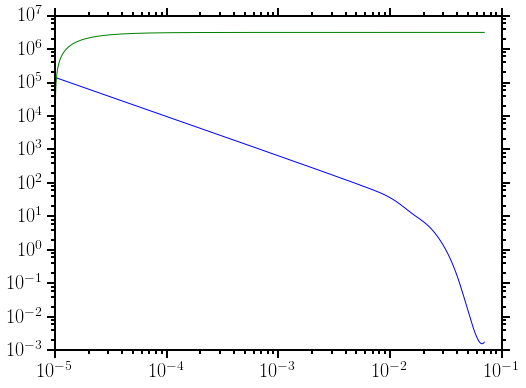

In [29]:
loglog(h_sur.x, h_sur.amp)
loglog(h_sur.x, h_sur.phase)

/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


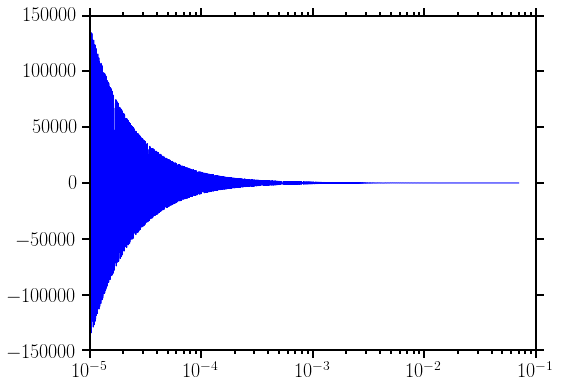

In [30]:
semilogx(h_sur.x, h_sur.amp * np.exp(1j * h_sur.phase))

## Ongoing testing of C code

In [11]:
x = np.array([1.0/1.5, 0.35, 0.32, 1.0, 1.0])
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

Choose parameters consistent with the test case above where the x array is defined.

In [12]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

Calling `SimIMRTEOBv4ROM` will print a bunch of debug output some of which I copy an paste in this notebook to compare.

In [13]:
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hp, hc = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max)
h = hp.data.data + 1j*hc.data.data
fHz = np.arange(hp.data.length)*hp.deltaF

In [14]:
# For comparison generate a TaylorF2 waveform
LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

hpTF2 = LS.SimInspiralTaylorF2(phiRef, deltaF,
                                      m1SI, m2SI, 
                                      chi1, chi2,
                                      fLow, fHigh, fRef, distance, LALpars)
# Compute the two polarizations
cfac = cos(inclination)
pfac = 0.5 * (1.0 + cfac**2)

fHzTF2 = np.arange(hpTF2.data.length)*hpTF2.deltaF

hpTF2_data = pfac * hpTF2.data.data
hcTF2_data = -1j*cfac * hpTF2.data.data
hTF2 = hpTF2_data +1j*hcTF2_data

In [15]:
def TEOB_surrogate_Python_compute_amplitude_phase_corrections(x, mfs):
    """
    MP assembled this from different pieces of code; want to have geometric frequency as an argument

    Parameters:
        x: 5D parameter space point (q<=1, chi1, chi2, lambda1, lambda2)
        mfs: array of geometric frequencies
    """
    filename = 'TEOBv4_surrogate.hdf5'
    fp = h5py.File(filename, 'r')

    # Compute amplitude and phase coefficients for an example point
    N_amp = len(fp['spline_nodes_amp'])
    N_phi = len(fp['spline_nodes_phase'])

    # Calculate waveform at nodes
    amp_at_nodes = np.array([gp_predict(x,
                                        fp['hyp_amp'][i], 
                                        fp['x_train'], 
                                        fp['kinv_dot_y_amp'][i]) 
                             for i in range(N_amp)])

    phase_at_nodes = np.array([gp_predict(x,
                                          fp['hyp_phi'][i], 
                                          fp['x_train'], 
                                          fp['kinv_dot_y_phi'][i]) 
                               for i in range(N_phi)])

    # In reconstruct_amp_phase_difference_spline():
    # Prepend the point [mf_a, 0] to the phase nodes
    mf_amp = fp['spline_nodes_amp'][:]
    mf_phase = fp['spline_nodes_phase'][:]
    mf_min = mf_amp[0] # Follow definition of mf_a in GPSplineSurrogate constructor
    mf_max = mf_amp[-1]
    #print [mf_min, mf_max]
    mf_phi = np.insert(mf_phase, 0, mf_min)
    phase_at_nodes = np.insert(phase_at_nodes, 0, 0.0)

    # Interpolate dlnamp and dphase at the frequencies mf_amp and mf_p
    ampoff = interpolate.UnivariateSpline(mf_amp, amp_at_nodes, k=3, s=0)
    phaseoff = interpolate.UnivariateSpline(mf_phi, phase_at_nodes, k=3, s=0)

    # Evaluate dlnamp and dphase at the frequencies mfs
    amp_interp = np.array([ampoff(f) if mf_min <= f <= mf_max else -np.inf if f > mf_max else 0.0 for f in mfs])
    phase_interp = np.array([phaseoff(f) if mf_min <= f <= mf_max else 0.0 for f in mfs])
    
    fp.close()
    
    return amp_interp, phase_interp

In [16]:
def TEOB_surrogate_Python(Mtot, x, fHz):
    Mtot_sec = Mtot * lal.MTSUN_SI
    mfs = fHz * Mtot_sec
    
    # Compute TaylorF2 reference waveform
    h_ref = geometric_reference_waveform(x, mfs)
    
    # Evaluate surrogate for amplitude and phase corrections
    amp_interp, phase_interp = TEOB_surrogate_Python_compute_amplitude_phase_corrections(x, mfs)
    
    # Surrogate of A and \Phi
    h_sur = h_ref.copy()
    h_sur.amp *= np.exp(amp_interp)
    h_sur.phase += phase_interp
    
    # switch conventions to agree with LAL
    #h_sur.phase = -h_sur.phase
    #h_sur.phase
    
    return h_sur

In [17]:
fHz_gt_fLow = fHz[np.where(fHz > fLow)]
h_sur = TEOB_surrogate_Python(Mtot, x, fHz_gt_fLow)

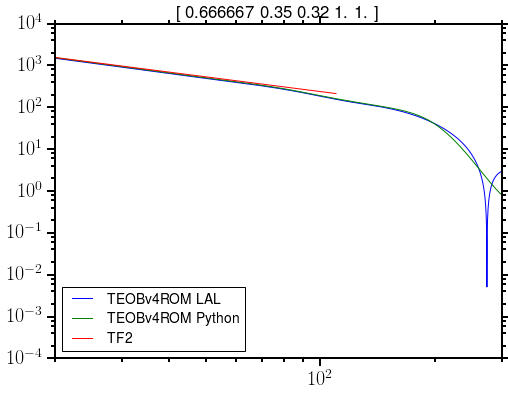

In [210]:
plt.loglog(fHz, np.abs(h), label='TEOBv4ROM LAL')
plt.loglog(fHz_gt_fLow, 12*h_sur.amp, label='TEOBv4ROM Python')
plt.loglog(fHzTF2, np.abs(hTF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlim([20, 300]);

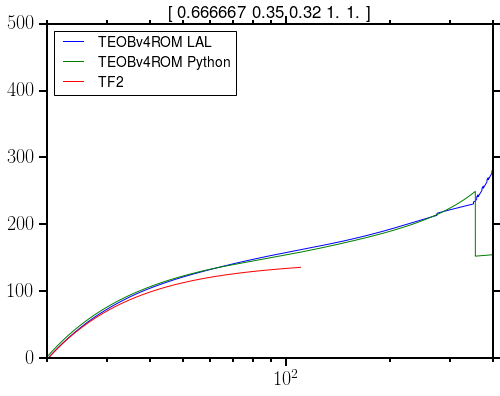

In [211]:
plt.semilogx(fHz, np.unwrap(np.angle(h)) + 1.0*fHz - 20, label='TEOBv4ROM LAL')
plt.semilogx(fHz_gt_fLow, h_sur.phase, label='TEOBv4ROM Python')
plt.semilogx(fHzTF2, np.unwrap(np.angle(hTF2)), label='TF2');
plt.legend(loc=2)
plt.title(x)
plt.xlim([20, 400]);
plt.ylim([0, 500]);

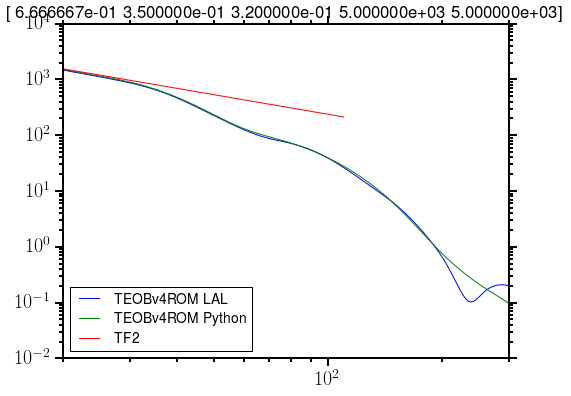

In [18]:
plt.loglog(fHz, np.abs(h), label='TEOBv4ROM LAL')
plt.loglog(fHz_gt_fLow, 12*h_sur.amp, label='TEOBv4ROM Python')
plt.loglog(fHzTF2, np.abs(hTF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlim([20, 300]);

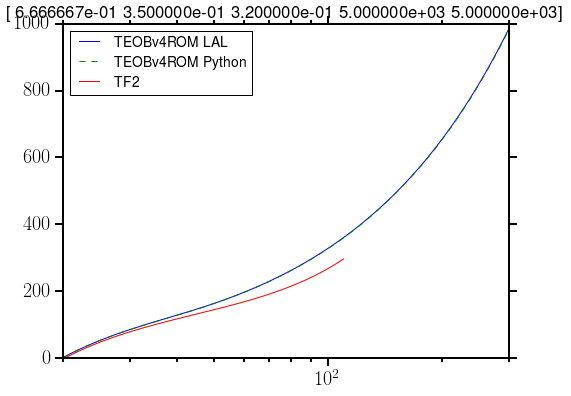

In [40]:
plt.semilogx(fHz, np.unwrap(np.angle(h)) + 0.5*fHz - 8, label='TEOBv4ROM LAL')
plt.semilogx(fHz_gt_fLow, h_sur.phase, 'g--', label='TEOBv4ROM Python')
plt.semilogx(fHzTF2, np.unwrap(np.angle(hTF2)), 'r-', label='TF2');
plt.legend(loc=2)
plt.title(x)
plt.xlim([20, 300]);
plt.ylim([0, 1000]);

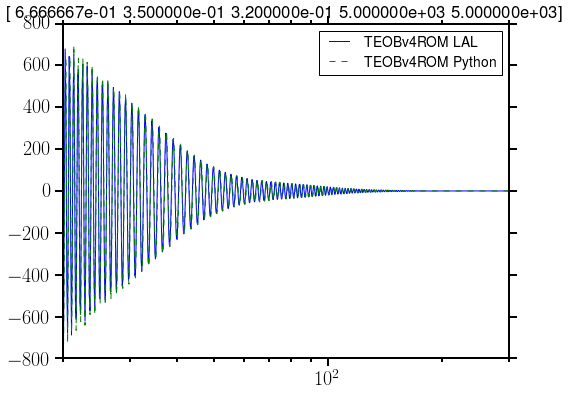

In [42]:
# also compare against Ben's python TEOBv4 surrogate
plt.semilogx(fHz, hp.data.data * np.exp(1j*(0.5*fHz - 8)), label='TEOBv4ROM LAL');
plt.semilogx(fHz_gt_fLow, 6*h_sur.complex(), 'g--', label='TEOBv4ROM Python');
#plt.semilogx(fHzTF2, hpTF2_data, 'r-', label='TF2');
plt.legend(loc=1)
plt.title(x)
plt.xlim([20, 300]);

* Use Ben's updated HDF5 file: TEOBv4_ROM.hdf5
* Implement checks on parameter bounds
* Implement checks on dataset sizes? Remove all hardwired sizes.

### Check PN phasing

In [34]:
# Copied from Terminal output
PN_phase_LAL = np.array([
19970.8623740172,
12015.6330086051,
7222.39483857474,
4333.99515435419,
2593.5166533687,
1545.04740751171,
913.851414121915,
534.276218281053,
306.364065763709,
169.722435590746,
87.7695257429162,
38.2079029306288,
7.21935977243947,
-14.1512904875418,
-32.3912245472999,
-53.3634320935435,
-84.1717930456965,
-135.7213025241,
-227.024821778381,
-393.163375831142])

In [35]:
h_ref_at_nodes = geometric_reference_waveform(x, mf_phi)

In [36]:
PN_phase_Python = h_ref_at_nodes.phase

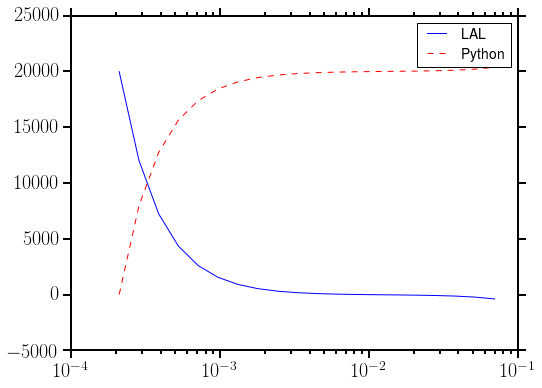

In [37]:
plt.semilogx(mf_phi, PN_phase_LAL, label='LAL')
plt.semilogx(mf_phi, PN_phase_Python, 'r--', label='Python')
plt.legend();

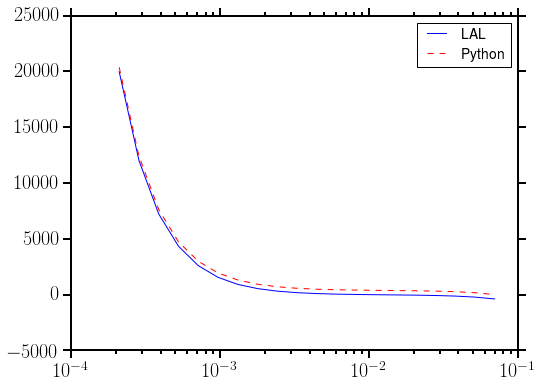

In [38]:
plt.semilogx(mf_phi, PN_phase_LAL, label='LAL')
plt.semilogx(mf_phi, -PN_phase_Python + max(PN_phase_Python), 'r--', label='Python')
plt.legend();

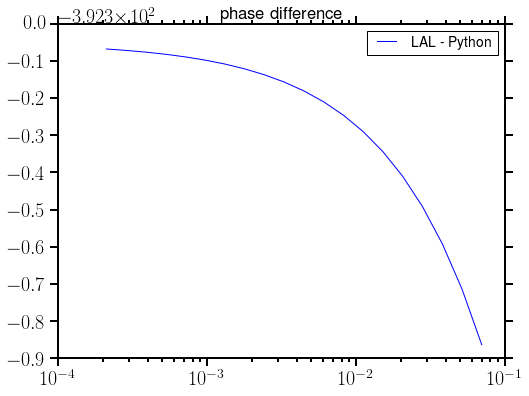

In [39]:
plt.semilogx(mf_phi, PN_phase_LAL - (-PN_phase_Python + max(PN_phase_Python)), label='LAL - Python')
plt.legend();
plt.title('phase difference');

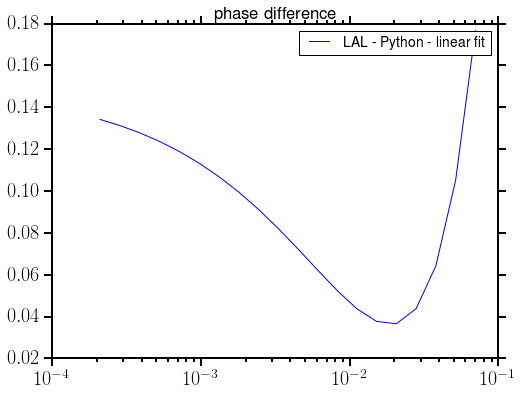

In [40]:
plt.semilogx(mf_phi, PN_phase_LAL - (-PN_phase_Python + max(PN_phase_Python)) + 392.5 + mf_phi*12, label='LAL - Python - linear fit')
plt.legend();
plt.title('phase difference');

Flipped sign of TF2 phase in LAL to, so there is agreement between the Python and LAL surrogate codes and the surrogate phase correction is applied in the correct direction.

## Obtain TF2 phase via SWIG-LAL and compare to LAL-C

As you can see at the end of this section, the agreement is very good.

In [43]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [44]:
extraParams = lal.CreateDict()
LS.SimInspiralWaveformParamsInsertPNSpinOrder(extraParams, LS.SIM_INSPIRAL_SPIN_ORDER_35PN);

m1OverM = q / (1.0+q);
m2OverM = 1.0 / (1.0+q);
m1 = Mtot * m1OverM
m2 = Mtot * m2OverM

pn = LS.SimInspiralTaylorF2AlignedPhasing(m1 * lal.MSUN_SI, m2 * lal.MSUN_SI, chi1, chi2, extraParams)

The returned structure contains the PN coefficients, except for the tidal terms which we add later.

In [45]:
pn.v

array([  0.097656,   0.      ,   0.623114,  -3.864351,   3.884858,   6.904976, -37.170777, -53.923996,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ])

In [46]:
pn.vlogv

array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,  20.714929, -31.845238,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ])

In [47]:
pn.vlogvsq

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [48]:
# Add tidal deformability terms

# Note: these functions are not callable outside this source file, even though they are XLAL
# Therefore I reimplement them here.
# See LALSimInspiralPNCoefficients.c

def XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(mByM):
    return (-288. + 264.*mByM)*mByM*mByM*mByM*mByM;

def XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(mByM):
    return (-15895./28. + 4595./28.*mByM + 5715./14.*mByM*mByM - 325./7.*mByM*mByM*mByM)*mByM*mByM*mByM*mByM;

print "Before adding tidal terms", pn.v[10], pn.v[12]

pn.v[10] = pn.v[0] * ( lambda1 * XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(m1OverM)
                     + lambda2 * XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(m2OverM) );
pn.v[12] = pn.v[0] * ( lambda1 * XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(m1OverM)
                     + lambda2 * XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(m2OverM) );

print "After adding tidal terms", pn.v[10], pn.v[12]

Before adding tidal terms 0.0 0.0
After adding tidal terms -2324.25 -5854.33928571


In [49]:
PN_phase_LAL_Python = []
for Mf in mf_phi:
    v = (lal.PI * Mf)**(1.0/3.0)
    logv = log(v)

    v2 = v * v;
    v3 = v * v2;
    v4 = v * v3;
    v5 = v * v4;
    v6 = v * v5;
    v7 = v * v6;
    v8 = v * v7;
    v9 = v * v8;
    v10 = v * v9;
    v12 = v2 * v10;
    phasing = 0.0;

    phasing += pn.v[7] * v7;
    phasing += (pn.v[6] + pn.vlogv[6] * logv) * v6;
    phasing += (pn.v[5] + pn.vlogv[5] * logv) * v5;
    phasing += pn.v[4] * v4;
    phasing += pn.v[3] * v3;
    phasing += pn.v[2] * v2;
    phasing += pn.v[1] * v;
    phasing += pn.v[0];

    # Tidal terms in phasing
    phasing += pn.v[12] * v12;
    phasing += pn.v[10] * v10;

    phasing /= v5;
    PN_phase_LAL_Python.append(phasing)
    #print phasing, pn.v[12] * v12, pn.v[10] * v10
    print Mf, v, phasing

PN_phase_LAL_Python = np.array(PN_phase_LAL_Python)

0.00021 0.0870541987232 19970.862374
0.000285103393483 0.0963941666465 12015.6330086
0.000387066404645 0.106736211461 7222.39483857
0.000525494978417 0.118187845109 4333.99515435
0.000713430483832 0.130868114395 2593.51665337
0.000968578342641 0.144908838548 1545.04740751
0.00131497605877 0.160455979567 913.851414122
0.00178525779382 0.177671159584 534.276218281
0.00242372883458 0.196733341027 306.364065764
0.00329053959819 0.217840687043 169.722435591
0.00446735240873 0.24121262153 87.7695257429
0.00606503491244 0.267092110181 38.2079029306
0.00823410492919 0.29574818626 7.21935977244
0.0111789107505 0.327478747377 -14.1512904875
0.0151768828115 0.36261365231 -32.3912245473
0.0206046704383 0.401518150092 -53.3634320935
0.0279736260169 0.444596677004 -84.1717930457
0.0379779795497 0.492297060936 -135.721302524
0.0515602421298 0.545115176838 -227.024821778
0.07 0.603600101643 -393.163375831


In [50]:
np.allclose(PN_phase_LAL, PN_phase_LAL_Python)

True

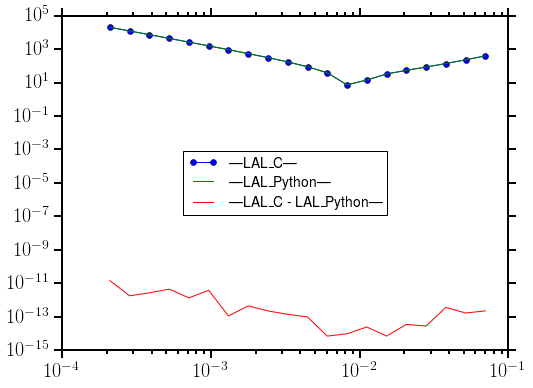

In [57]:
plt.loglog(mf_phi, np.abs(PN_phase_LAL), 'o-', label=r'|LAL\_C|')
plt.loglog(mf_phi, np.abs(PN_phase_LAL_Python), label=r'|LAL\_Python|')
plt.loglog(mf_phi, np.abs(PN_phase_LAL - PN_phase_LAL_Python), '-', label=r'|LAL\_C - LAL\_Python|')
plt.legend(loc=10);

## 1PN amplitude

In [33]:
def taylorf2_amp_1pn(mf, eta):
    """1PN point-particle amplitude. where h(f) = h_+(f) + i h_x(f).
    Expression from Eq. (6.10) of arXiv:0810.5336.
    !!! This is technically wrong since you have a x**2 term (need to re-expand). !!!
    Parameters
    ----------
    mf : numpy array or float
        Geometric frequency. Most efficient when mf is a numpy array.
    Returns
    -------
    amp : numpy array or float
        Amplitude of h(f) = h_+(f) + i h_x(f) in geometric units.
    """
    x = (np.pi*mf)**(2.0/3.0)
    a00 = np.sqrt( (5.0*np.pi/24.0)*eta )
    a10 = -323./224. + 451.*eta/168.
    return 2.0*a00 * x**(-7./4.) * (1. + a10*x)

In [35]:
def etafun(q):
    return q / (1.0+q)**2

In [41]:
AmpPN_at_nodes_Python = taylorf2_amp_1pn(mf_phi, etafun(q))

In [40]:
AmpPN_at_nodes_LAL_C = np.array([
4047.5531555559,
2829.31539991122,
1977.12411513888,
1381.0801975125,
964.267436079086,
672.85545231024,
469.17216669043,
326.854846797055,
227.456096268303,
158.068251790255,
109.660626591625,
75.9157159577056,
52.4146520685744,
36.0671141726683,
24.7123420619561,
16.8399093393479,
11.3943183049892,
7.63826154705543,
5.05694324100059,
3.29113642458537])

In [42]:
np.allclose(AmpPN_at_nodes_Python, AmpPN_at_nodes_LAL_C)

True

In [43]:
AmpPN_at_nodes_Python - AmpPN_at_nodes_LAL_C

array([ -4.547474e-13,  -3.183231e-12,  -1.591616e-12,   0.000000e+00,   4.547474e-13,  -3.410605e-13,
        -2.842171e-13,  -4.547474e-13,   4.547474e-13,   3.979039e-13,  -2.842171e-14,   1.421085e-14,
         4.263256e-14,   4.973799e-14,  -3.907985e-14,   2.842171e-14,   2.309264e-14,  -6.217249e-15,
         0.000000e+00,   1.776357e-15])

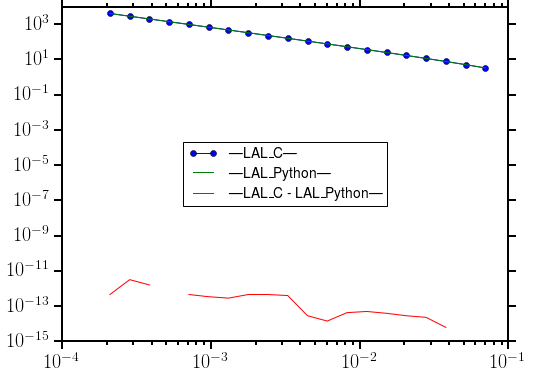

In [45]:
plt.loglog(mf_phi, np.abs(AmpPN_at_nodes_LAL_C), 'o-', label=r'|LAL\_C|')
plt.loglog(mf_phi, np.abs(AmpPN_at_nodes_Python), label=r'|LAL\_Python|')
plt.loglog(mf_phi, np.abs(AmpPN_at_nodes_LAL_C - AmpPN_at_nodes_Python), '-', label=r'|LAL\_C - LAL\_Python|')
plt.legend(loc=10);

## Test cases for regression test

In [120]:
x = np.array([1.0/1.5, 0.35, 0.32, 1.0, 1.0])
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [121]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [122]:
# SEOBNRv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpSEOBNRv4, hcSEOBNRv4 = LS.SimIMRSEOBNRv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, nk_max)

fHz_SEOBNRv4 = np.arange(hpSEOBNRv4.data.length)*hpSEOBNRv4.deltaF
h_SEOBNRv4 = hpSEOBNRv4.data.data + 1j*hcSEOBNRv4.data.data

In [123]:
# TEOBv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpTEOBv4, hcTEOBv4 = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max)

fHz_TEOBv4 = np.arange(hpTEOBv4.data.length)*hpTEOBv4.deltaF
h_TEOBv4 = hpTEOBv4.data.data + 1j*hcTEOBv4.data.data

In [124]:
# TaylorF2
LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

hpTF2 = LS.SimInspiralTaylorF2(phiRef, deltaF,
                                      m1SI, m2SI, 
                                      chi1, chi2,
                                      fLow, fHigh, fRef, distance, LALpars)
# Compute the two polarizations
cfac = cos(inclination)
pfac = 0.5 * (1.0 + cfac**2)

hpTF2_data = pfac * hpTF2.data.data
hcTF2_data = -1j*cfac * hpTF2.data.data
h_TF2 = hpTF2_data +1j*hcTF2_data
fHz_TF2 = np.arange(hpTF2.data.length)*hpTF2.deltaF

In [125]:
# TEOBv4 FFT via SimInspiralFD
longAscNodes, eccentricity, meanPerAno = 0,0,0

LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

# Nyquist frequency is set by fHigh
# Can set deltaF = 0 to figure out required frequency spacing
hpTEOBv4FD, hcTEOBv4FD = LS.SimInspiralFD(m1SI, m2SI,
                 0.0, 0.0, chi1,
                 0.0, 0.0, chi2,
                 distance, inclination, phiRef, 
                 longAscNodes, eccentricity, meanPerAno, 
                 0.0,
                 fLow, 16384, fRef,
                 LALpars,
                 LS.TEOBv4)

fHz_TEOBv4FD = np.arange(hpTEOBv4FD.data.length)*hpTEOBv4FD.deltaF
h_TEOBv4FD = hpTEOBv4FD.data.data + 1j*hcTEOBv4FD.data.data

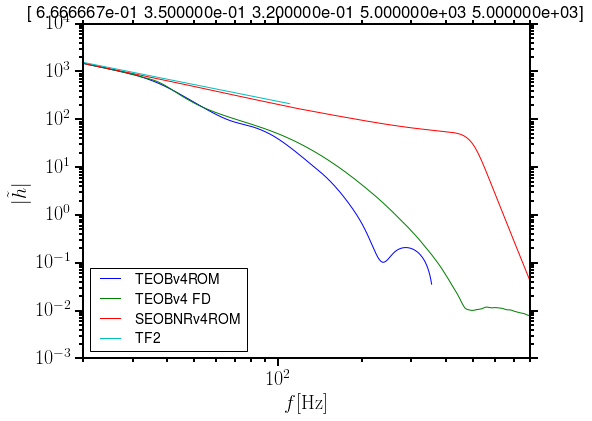

In [126]:
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM')
plt.loglog(fHz_TEOBv4FD, np.abs(h_TEOBv4FD), label='TEOBv4 FD')
plt.loglog(fHz_SEOBNRv4, np.abs(h_SEOBNRv4), label='SEOBNRv4ROM')
plt.loglog(fHz_TF2, np.abs(h_TF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 800]);
plt.ylim([1e-3, 1e4]);

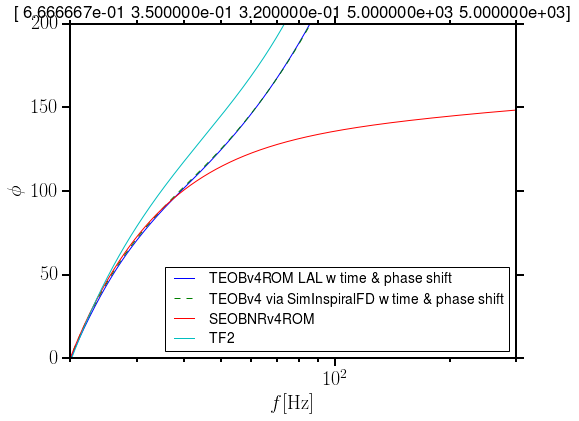

In [74]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) - 0.7*fHz_TEOBv4 + 13, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TEOBv4FD, np.unwrap(np.angle(h_TEOBv4FD)) + 1.9*fHz_TEOBv4FD + 25, 'g--', label='TEOBv4 via SimInspiralFD  w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 300]);
plt.ylim([0, 200]);

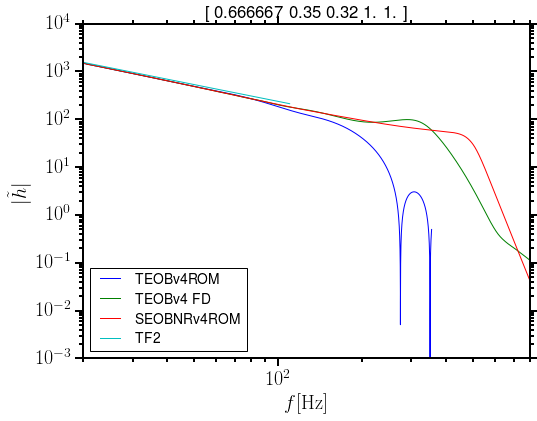

In [82]:
# There is some artefact : TEOBv4ROM should use a parameter dependent BNS merger cutoff frequency
# The amplitude is very different between the surrogate and the FFT of the TD model - do they agree well in the TD for these parameters?
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM')
plt.loglog(fHz_TEOBv4FD, np.abs(h_TEOBv4FD), label='TEOBv4 FD')
plt.loglog(fHz_SEOBNRv4, np.abs(h_SEOBNRv4), label='SEOBNRv4ROM')
plt.loglog(fHz_TF2, np.abs(h_TF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 800]);
plt.ylim([1e-3, 1e4]);

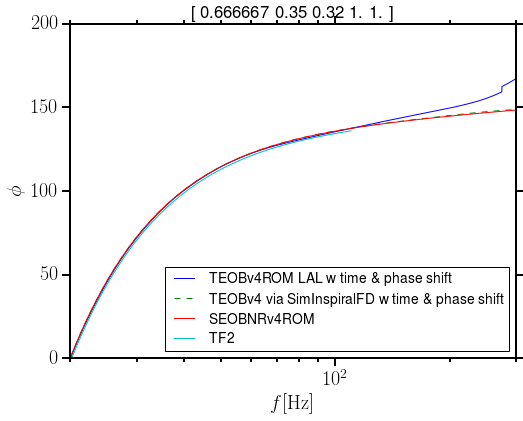

In [118]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 0.28*fHz_TEOBv4 - 6, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TEOBv4FD, np.unwrap(np.angle(h_TEOBv4FD)) - 0.125*fHz_TEOBv4FD + 131, 'g--', label='TEOBv4 via SimInspiralFD  w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 300]);
plt.ylim([0, 200]);

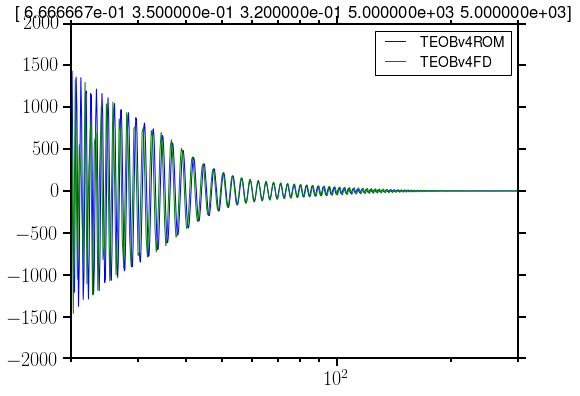

In [128]:
plt.semilogx(fHz_TEOBv4, np.real(h_TEOBv4 * np.exp(1j*(-0.7*fHz_TEOBv4 + 13))), label='TEOBv4ROM');
plt.semilogx(fHz_TEOBv4FD, np.real(h_TEOBv4FD * np.exp(1j*(+1.9*fHz_TEOBv4FD + 25))), label='TEOBv4FD');
#plt.semilogx(fHz_SEOBNRv4, np.real(h_SEOBNRv4), label='SEOBNRv4ROM');
#plt.semilogx(fHz_TF2, h_TF2.real, label='TF2');
plt.legend()
plt.title(x)
plt.xlim([20, 300]);

## Regression test for LAL C code for TEOBv4ROM

In [129]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [130]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [141]:
DR = '/Users/mpuer/Documents/gpsurrogate/src/TEOB-LAL-implementation/regression-data/'
file_name = DR+'TEOBv4ROM_reg_data_%g_%g_%g_%g_%g.npy'%(q,chi1,chi2,lambda1,lambda2)

### Save TEOBv4ROM regression data

Cell was converted into Markdown to avoid overwriting the regression data

```Python
# TEOBv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpTEOBv4, hcTEOBv4 = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max)

fHz_TEOBv4 = np.arange(hpTEOBv4.data.length)*hpTEOBv4.deltaF
h_TEOBv4 = hpTEOBv4.data.data + 1j*hcTEOBv4.data.data

np.save(file_name, np.vstack([fHz_TEOBv4, h_TEOBv4]))
```

### Load regression data and compare against new TEOBv4ROM waveform

In [153]:
fHz_TEOBv4_reg, h_TEOBv4_reg = np.load(file_name)

In [154]:
np.allclose(fHz_TEOBv4, fHz_TEOBv4_reg) & np.allclose(h_TEOBv4, h_TEOBv4_reg)

True

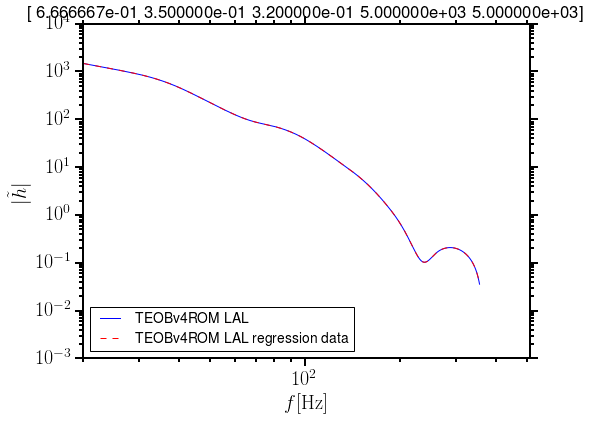

In [166]:
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM LAL')
plt.loglog(fHz_TEOBv4_reg, np.abs(h_TEOBv4_reg), 'r--', label='TEOBv4ROM LAL regression data')
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 512]);
plt.ylim([1e-3, 1e4]);

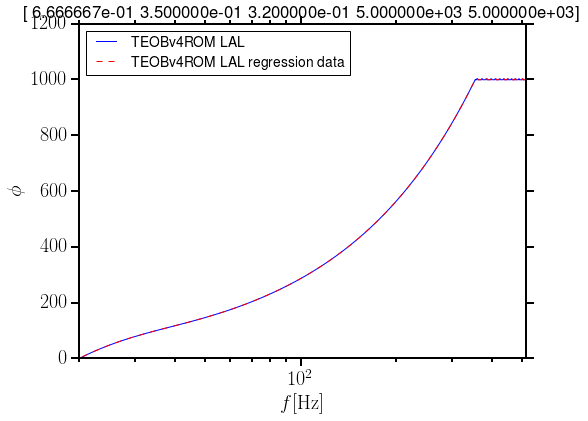

In [167]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)), label='TEOBv4ROM LAL')
plt.semilogx(fHz_TEOBv4_reg, np.unwrap(np.angle(h_TEOBv4_reg)), 'r--', label='TEOBv4ROM LAL regression data')
plt.legend(loc=2)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 512]);